In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import * 
from scipy.optimize import newton
from scipy.optimize import fsolve
import math
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import norm
from scipy.optimize import fsolve
from tabulate import tabulate
import time 

## LECTURE - 7 [Exotic Options, Variance Swaps, Jump-Diffusions]

### Q.1 (a)

In [3]:
def calculate_option_price(T, lambda_1):
    np.random.seed(57)
    initial_value = 20000  # Initial value of V
    initial_loan = 22000   # Initial value of L
    drift_rate = -0.1      # Drift rate for V
    volatility = 0.2       # Volatility for V
    jump_intensity = -0.4  # Intensity of jumps for V
    initial_interest_rate = 0.055  
    delta = 0.25         
    lambda_2 = 0.4        
    alpha = 0.7            
    epsilon = 0.95         
    beta = (epsilon - alpha) / T

    num_simulations = 10000
    num_steps = 12 * T
    total_payments = T * 12  # Total number of payments
    monthly_interest_rate = (initial_interest_rate + delta * lambda_2) / 12
    dt = 1 / 12

    # Calculate PMT (monthly payment)
    PMT = (initial_loan * monthly_interest_rate) / (1 - (1 / (1 + monthly_interest_rate)**total_payments))

    # Calculate intermediate constants a, b, and c
    a = PMT / monthly_interest_rate
    b = PMT / (monthly_interest_rate * (1 + monthly_interest_rate)**total_payments)
    c = 1 + monthly_interest_rate

    # Set random seed for reproducibility
    np.random.seed(57)

    # Initialize arrays to store the results
    asset_values = np.zeros((num_simulations, num_steps + 1))
    asset_values[:, 0] = initial_value  # Set the initial value of V
    interest_rate_shocks = np.random.randn(num_simulations, num_steps + 1)
    poisson_jumps = np.random.poisson(lam=(lambda_1 * T / num_steps), size=(num_simulations, num_steps + 1))

    loan_values = np.zeros((num_steps + 1))
    proportion_repaid = np.zeros((num_steps + 1))
    proportion_repaid[0] = alpha
    payoffs = np.zeros((num_simulations, num_steps + 1))
    default_flags = np.zeros((num_simulations, num_steps + 1))

    # Simulation loop
    for i in range(num_simulations):
        default_occurred = False
        for j in range(1, num_steps + 1):
            loan_values[j - 1] = a - (b * c**(j - 1))
            proportion_repaid[j] = alpha + beta * (j) / 12

            # Update asset value
            asset_values[i, j] = asset_values[i, j - 1] * np.exp(
                (drift_rate - 0.5 * volatility**2) * dt + 
                volatility * np.sqrt(dt) * interest_rate_shocks[i, j]
            ) * (1 + jump_intensity * poisson_jumps[i, j])

            if not default_occurred and asset_values[i, j] < proportion_repaid[j] * loan_values[j - 1]:
                default_occurred = True
                default_flags[i, j] = 1
                payoffs[i, j] = np.exp(-j / 12 * initial_interest_rate) * max(0, loan_values[j - 1] - epsilon * asset_values[i, j]) * default_flags[i, j]

    # Calculate the option price
    option_price = np.sum(payoffs) / num_simulations

    # Calculate expected exercise time and default intensity
    default_times = default_flags * np.arange(default_flags.shape[1])
    expected_exercise_time = np.mean(default_times[np.where(default_times != 0)]) / 12
    default_intensity = len(default_times[np.where(default_times != 0)]) / num_simulations

    return option_price, default_intensity, expected_exercise_time

# Example usage
T = 5
lambda_1 = 0.2
option_price, default_intensity, expected_exercise_time = calculate_option_price(T, lambda_1)
print(f"Price of the default option is ${option_price:.4f}")

Price of the default option is $4230.1745


### Q.1 (b)

In [4]:
print(f"Default Intensity is {default_intensity:.4f}")

Default Intensity is 0.6607


### Q.1 (c)

In [5]:
print(f"Expected Exercise Time is {expected_exercise_time:.4f} years")

Expected Exercise Time is 1.2232 years


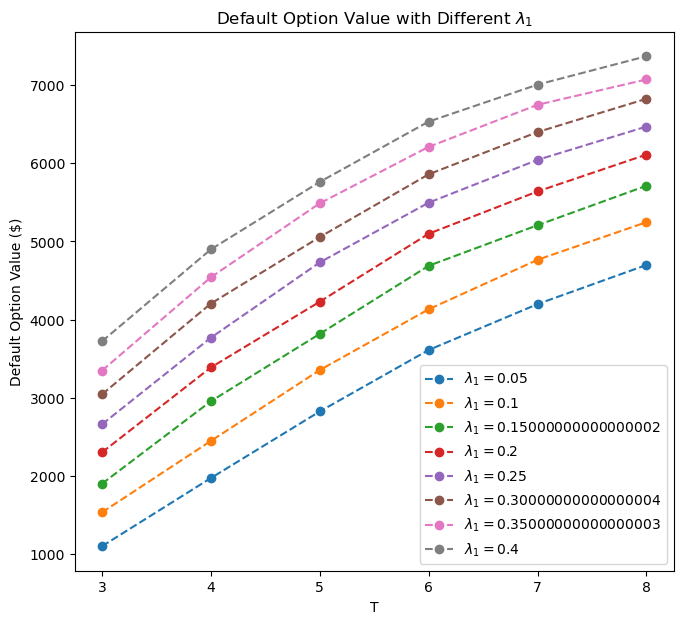

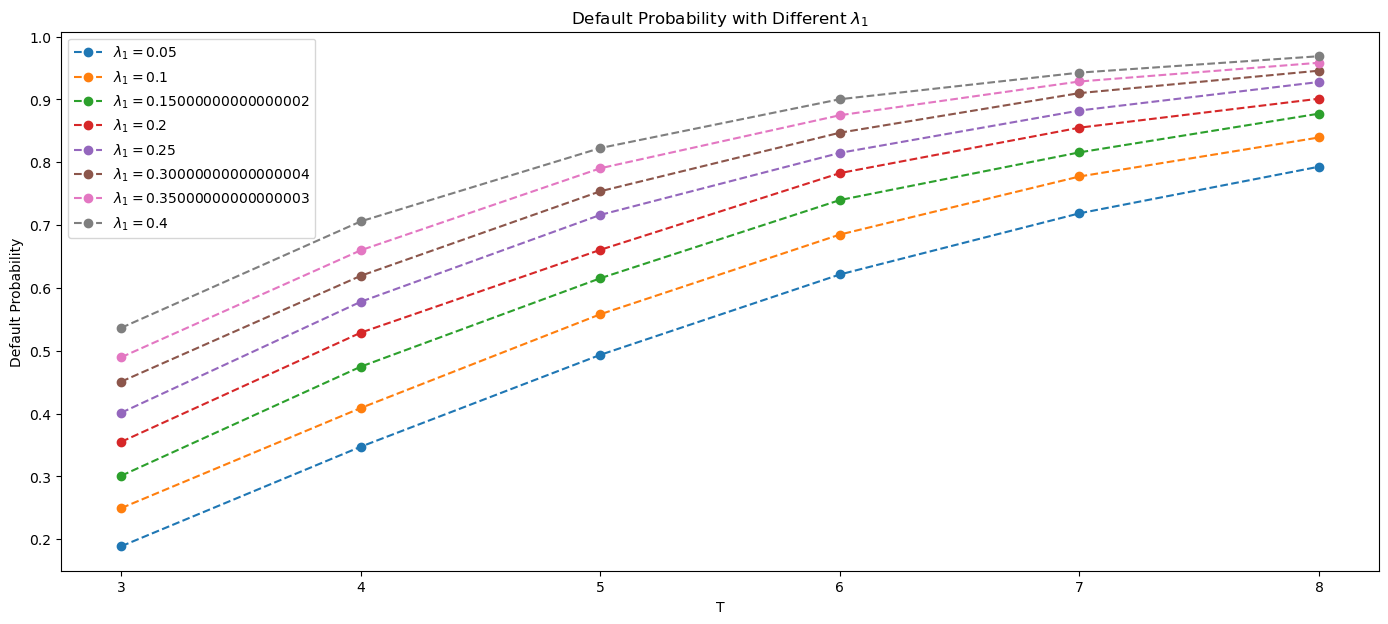

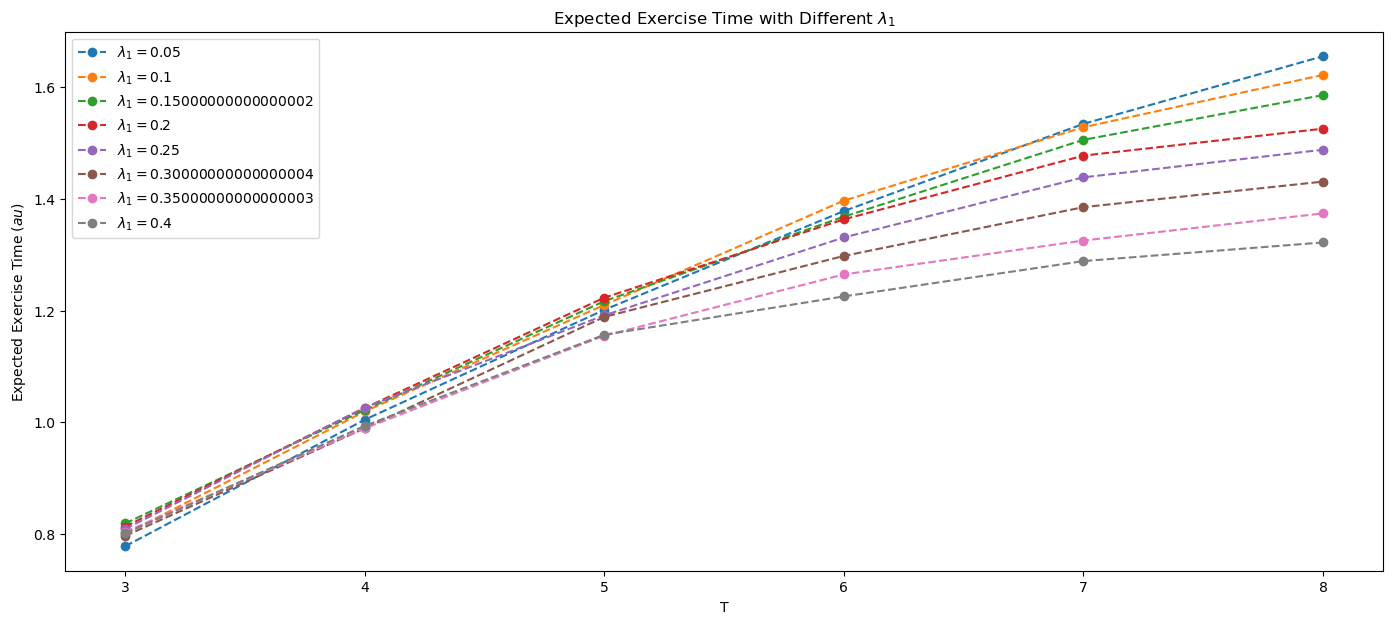

In [6]:
def plot_func(seed):
    np.random.seed(seed)
    lambda_1 = 0.2
    T = 5
    loan = pd.DataFrame(calculate_option_price(T, lambda_1), index=['Option Value', 'Default Probability', 'Expected Exercise Time'])
    loan.columns = ['Values']
    lambda_1_values = np.arange(0.05, 0.45, 0.05)
    time_values = np.arange(3, 9, 1)
    
    option_values = []
    for lam1 in lambda_1_values:
        for T in time_values:
            option_values.append(calculate_option_price(T, lam1)[0])
    option_values = np.array(option_values).reshape((len(lambda_1_values), len(time_values)))

    plt.figure(figsize=(17, 7))
    plt.subplot(1, 2, 1)
    for i in range(len(option_values)):
        plt.plot(time_values, option_values[i], linestyle='--', marker='o', label=f'$\lambda_1 = {lambda_1_values[i]}$')

    plt.legend()
    plt.xlabel('T')
    plt.ylabel('Default Option Value ($)')
    plt.title('Default Option Value with Different $\lambda_1$')
    plt.savefig("Proj6_2a.jpg")
    plt.show()

    default_intensity_values = []
    for lam1 in lambda_1_values:
        for T in time_values:
            default_intensity_values.append(calculate_option_price(T, lam1)[1])
    default_intensity_values = np.array(default_intensity_values).reshape((len(lambda_1_values), len(time_values)))

    plt.figure(figsize=(17, 7))
    for i in range(len(default_intensity_values)):
        plt.plot(time_values, default_intensity_values[i], linestyle='--', marker='o', label=f'$\lambda_1 = {lambda_1_values[i]}$')

    plt.legend()
    plt.xlabel('T')
    plt.ylabel('Default Probability')
    plt.title('Default Probability with Different $\lambda_1$')
    plt.savefig("Proj6_2b.jpg")
    plt.show()

    expected_exercise_times = []
    for lam1 in lambda_1_values:
        for T in time_values:
            expected_exercise_times.append(calculate_option_price(T, lam1)[2])
    expected_exercise_times = np.array(expected_exercise_times).reshape((len(lambda_1_values), len(time_values)))

    plt.figure(figsize=(17, 7))
    for i in range(len(expected_exercise_times)):
        plt.plot(time_values, expected_exercise_times[i], linestyle='--', marker='o', label=f'$\lambda_1 = {lambda_1_values[i]}$')

    plt.legend()
    plt.xlabel('T')
    plt.ylabel('Expected Exercise Time ($\tau$)')
    plt.title('Expected Exercise Time with Different $\lambda_1$')
    plt.savefig("Proj6_2c.jpg")
    plt.show()

# Call the function
plot_func(seed=57)

### Q.2 (a)

In [27]:
# Parameters
M = 1000      # Number of time steps
N = 10000     # Number of simulations
r = 0.05      # Risk-free rate
rho = -0.75   # Correlation between Wt and Bt
alpha = 0.45
beta = -5.105
gamma = 0.25
S0 = 100      # Initial stock price
V0 = 0.1      # Initial volatility
K = 100       # Strike price
T = 1         # Time to maturity
barrier = 94        # Barrier

dt = T / M    # Time step size
payoffs = np.zeros(N)

np.random.seed(57)

# Monte Carlo simulation
for i in range(N):
    stock_prices = np.zeros(M + 1)
    volatilities = np.zeros(M + 1)
    stock_prices[0] = S0
    volatilities[0] = V0

    Z1 = np.random.normal(0, 1, M + 1)
    Z2 = np.random.normal(0, 1, M + 1)
    dW = np.sqrt(dt) * Z1
    dB = rho * dW + np.sqrt(1 - rho**2) * Z2 * np.sqrt(dt)

    flag = True
    for j in range(M):
        vol_sqrt = np.sqrt(max(volatilities[j], 0))
        stock_prices[j + 1] = stock_prices[j] + (r * stock_prices[j] * dt) + stock_prices[j] * vol_sqrt * dW[j + 1]
        volatilities[j + 1] = volatilities[j] + (alpha + beta * max(volatilities[j], 0)) * dt + gamma * vol_sqrt * dB[j + 1]

        if stock_prices[j + 1] <= barrier:
            payoffs[i] = 0
            flag = False
            break

    if flag:
        payoffs[i] = max(K - stock_prices[M], 0)

# Discounted payoff
expected_payoff = np.exp(-r * T) * np.mean(payoffs)
print(f"Price of the do put option with a fixed barrier is ${expected_payoff:.6f}")

Price of the do put option with a fixed barrier is $0.009513


### Q.2(b)

In [28]:
def do_put_price_1(S0, K, T, r, V0, alpha, beta, gamma, rho, N, M):
    
    np.random.seed(57)
    dt = T / M
    exp_factor = np.exp(-r * T)
    payoffs = np.zeros(N)

    for i in range(N):
        stock_price = S0
        volatility = V0
        flag = True
        for j in range(1, M + 1): 
            t = j * dt
            barrier = (6 / T) * t + 91 
            
            Z1 = np.random.normal()
            Z2 = np.random.normal()
            dW = np.sqrt(dt) * Z1
            dB = np.sqrt(dt) * (rho * Z1 + np.sqrt(1 - rho**2) * Z2)
            
            volatility += (alpha + beta * max(volatility, 0)) * dt + gamma * np.sqrt(max(volatility, 0)) * dB
            stock_price += (r * stock_price * dt) + (stock_price * np.sqrt(max(volatility, 0)) * dW)
            
            if stock_price <= barrier:
                payoffs[i] = 0
                flag = False
                break
        if flag:
            payoffs[i] = max(K - stock_price, 0)
    
    return exp_factor * np.mean(payoffs)

price = do_put_price_1(
    S0 = 100, K = 100, T = 1, r = 0.05, V0 = 0.1,
    alpha = 0.45, beta = -5.105, gamma = 0.25,
    rho = -0.75, N = 10000, M = 1000
)
print(f"Price of the do put option with a time-dependent moving barrier is ${price:.6f}")

Price of the do put option with a time-dependent moving barrier is $0.002135


### Q.2(c)

In [29]:
def do_put_price_2(S0, K, T, r, V0, alpha, beta, gamma, rho, N, M):

    np.random.seed(57)
    dt = T / M
    exp_factor = np.exp(-r * T)
    payoffs = np.zeros(N)

    for i in range(N):
        stock_price = S0
        volatility = V0
        flag = True
        for j in range(1, M + 1): 
            t = j * dt
            barrier = -(6 / T) * t + 97
            
            Z1 = np.random.normal()
            Z2 = np.random.normal()
            dW = np.sqrt(dt) * Z1
            dB = np.sqrt(dt) * (rho * Z1 + np.sqrt(1 - rho**2) * Z2)
            
            volatility += (alpha + beta * max(volatility, 0)) * dt + gamma * np.sqrt(max(volatility, 0)) * dB
            stock_price += (r * stock_price * dt) + (stock_price * np.sqrt(max(volatility, 0)) * dW)
            
            if stock_price <= barrier:
                payoffs[i] = 0
                flag = False
                break
        if flag:
            payoffs[i] = max(K - stock_price, 0)
    
    return exp_factor * np.mean(payoffs)

price = do_put_price_2(
    S0 = 100, K = 100, T = 1, r = 0.05, V0 = 0.1,
    alpha = 0.45, beta = -5.105, gamma = 0.25,
    rho = -0.75, N = 10000, M = 1000
)
print(f"The price of the down-and-out put option with a time-dependent barrier is ${price:.6f}")

The price of the down-and-out put option with a time-dependent barrier is $0.013583


## LECTURE - 8 [Fixed Income Securities]

### Q.3 (a)

In [30]:
def simulate_discount_factors(T, num_steps, num_simulations, initial_rate, kappa, mean_rate, volatility, t = 0, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    dt = (T - t) / num_steps
    discount_factors = []

    for _ in range(num_simulations):
        rates = np.zeros(num_steps + 1)
        rates[0] = initial_rate
        for i in range(1, num_steps + 1):
            Z = np.random.normal()
            rates[i] = rates[i-1] + kappa * (mean_rate - rates[i-1]) * dt + volatility * np.sqrt(dt * rates[i-1]) * Z
        
        discount_factors.append(np.exp(-np.sum(rates[1:]) * dt))
        
    return np.mean(discount_factors)

# Parameters
initial_rate = 0.05
mean_rate = 0.055
volatility = 0.12
num_steps = 10000
num_simulations = 1000
kappa = 0.92
T_values = np.arange(0.5, 4.1, 0.5)

# Seed for reproducibility
seed = 57

discount_factors = [simulate_discount_factors(T, num_steps, num_simulations, initial_rate, kappa, mean_rate, volatility, 0, seed) for T in T_values]
coupon_values = np.array([30, 30, 30, 30, 30, 30, 30, 1030])

bond_value = np.dot(coupon_values, discount_factors)
print(f"Price of the Coupon Paying Bond is ${bond_value:.6f}")

Price of the Coupon Paying Bond is $1019.588143


### Q.3 (b)

In [54]:
def simulate_discount_factors(T, m, N, r0, kappa, r_bar, sigma, t = 0):
    dt = (T-t) / m
    r_simulations = []

    for j in range(N):
        r = np.zeros(m+1)
        r[0] = r0
        for i in range(1, m+1):
            Z = np.random.normal()
            r[i] = r[i-1] + kappa * (r_bar - r[i-1]) * dt + sigma * np.sqrt(dt * r[i-1]) * Z
        
        r_simulations.append(np.exp(-np.sum(r[1:]) * dt))
        
    return np.mean(r_simulations)

option_price = []
r0 = 0.05
r_bar = 0.055
sigma = 0.12
m = 10000
N = 1000
kappa = 0.92
K = 980
T = 0.5
dt = T/m

for j in range(N):
    r = np.zeros(m+1)
    r[0] = r0 
    for i in range(m): 
        Z = np.random.normal()
        r[i + 1] = r[i] + kappa * (r_bar - r[i]) * dt + sigma * np.sqrt(dt * r[i]) * Z
    R = -np.sum(r)*dt
    P_values = simulate_discount_factors(T = 1, m = 1000, N = 100, r0 = r[i+1], kappa = 0.92, r_bar = 0.055, sigma = 0.12, t = T) * 1000
    Payoff = np.max([P_values - K, 0])
    option_price.append(np.exp(R)*Payoff)

print(f"Price of the European Call Option is is ${np.mean(option_price):.6f}")

Price of the European Call Option is is $0.377003


### Q.3 (c)

In [55]:
# Parameters
t = 0
T = 0.5
S = 1
r0 = 0.05  
sigma = 0.12  
kappa = 0.92  
r_bar = 0.055  
K = 980
FV = 1000

def CIR_closed_form_solution(t, T, rt, kappa, theta, sigma):
    h1 = np.sqrt(kappa ** 2 + 2 * sigma ** 2)
    h2 = (kappa + h1) / 2
    h3 = (2 * kappa * theta) / sigma ** 2
    
    A = ((h1 * np.exp(h2 * (T - t))) / (h2 * (np.exp(h1 * (T - t)) - 1) + h1)) ** h3
    B = (np.exp(h1 * (T - t)) - 1) / (h2 * (np.exp(h1 * (T - t)) - 1) + h1)
    
    P = A * np.exp(-B * rt)
    
    return P

# Grid parameters
M = 1000
delta_t = T / M
N = 150
delta_r = 0.001

# Initialize Call prices dataframe
call_prices = pd.DataFrame(np.zeros((N, M)))
call_price_cols = ["T=" + str(round(new_t, 4)) for new_t in np.arange(delta_t, T + delta_t, delta_t)]
call_prices.columns = call_price_cols

# Interest rates
interest_rates_max = N * delta_r
interest_rates = np.arange(interest_rates_max, 0, -delta_r)
terminal_values = [FV * CIR_closed_form_solution(t=T, T=S, rt=r0, kappa=kappa, theta=r_bar, sigma=sigma) for r0 in interest_rates]
terminal_values_df = pd.DataFrame(np.array(terminal_values) - K, columns=["Payoff"])
terminal_values_df['zero'] = 0
call_prices.loc[:, 'T=0.5'] = terminal_values_df.max(axis=1).values
call_prices.index = np.arange(N, 0, -1)

# Implement Matrix A
A_matrix = pd.DataFrame(np.zeros((N - 1, N - 1)))[1:N]
A_matrix = A_matrix.drop(0, axis=1)
A_matrix.index = np.arange(N - 1, 1, -1)

for col, j in enumerate(range(N - 1, 1, -1)):
    Pu = delta_t * ((-sigma ** 2 * j / (2 * delta_r)) + (-kappa * r_bar / (2 * delta_r)) + (kappa * j / 2))
    Pm = delta_t * (1 / delta_t + sigma ** 2 * j / delta_r + j * delta_r)
    Pd = delta_t * ((-sigma ** 2 * j / (2 * delta_r)) + (kappa * r_bar / (2 * delta_r)) - (kappa * j / 2))
    
    if j == 2:
        A_matrix.loc[j, col:col + 2] = [Pu, Pm]
    elif j == N - 1:
        A_matrix.loc[j, col + 1:col + 2] = [Pm, Pd]
    else:
        A_matrix.loc[j, col:col + 2] = [Pu, Pm, Pd]

# Calculate call prices
call_price_columns = call_prices.columns[::-1]
boundary_condition = []
inv_A = np.linalg.inv(A_matrix)

for i, call_column in enumerate(call_price_columns[1:]):
    prev_col = call_price_columns[i]
    
    B_vector = pd.DataFrame(np.zeros((N - 1)))[0:-1]
    B_vector.index = A_matrix.index
    Pd = delta_t * ((-sigma ** 2 * 1 / (2 * delta_r)) + (kappa * r_bar / (2 * delta_r)) - (kappa * 1 / 2))
    
    boundary_value = (CIR_closed_form_solution(t=T - (i + 1) * delta_t, T=S, rt=interest_rates[-1], kappa=kappa, theta=r_bar, sigma=sigma) * FV - K)
    B_vector.loc[2,] = Pd * boundary_value
    call_prices.loc[1, call_column] = boundary_value
    
    boundary_condition.append(B_vector.loc[2, 0])
    
    C_i = call_prices.loc[B_vector.index, prev_col] - B_vector.loc[:, 0]
    
    call_prices.loc[B_vector.index, call_column] = np.linalg.inv(A_matrix).dot(C_i.values)

i = i + 1
prev_col = call_price_columns[i]
B_vector = pd.DataFrame(np.zeros((N - 1)))[0:-1]
B_vector.index = A_matrix.index

Pd = delta_t * ((-sigma ** 2 * 1 / (2 * delta_r)) + (kappa * r_bar / (2 * delta_r)) - (kappa * 1 / 2))

boundary_value = (CIR_closed_form_solution(t=T - (i + 1) * delta_t, T=S, rt=interest_rates[-1], kappa=kappa, theta=r_bar, sigma=sigma) * FV - K)
call_column = "T=0"

B_vector.loc[2,] = Pd * boundary_value
call_prices.loc[1, call_column] = boundary_value

boundary_condition.append(B_vector.loc[2, 0])

C_i = call_prices.loc[B_vector.index, prev_col] - B_vector.loc[:, 0]

call_prices.loc[B_vector.index, call_column] = np.linalg.inv(A_matrix).dot(C_i.values)
call_prices.index = interest_rates

# Output the call prices
call_prices.head()

,T=0.0005,T=0.001,T=0.0015,T=0.002,T=0.0025,T=0.003,T=0.0035,T=0.004,T=0.0045,T=0.005,...,T=0.496,T=0.4965,T=0.497,T=0.4975,T=0.498,T=0.4985,T=0.499,T=0.4995,T=0.5,T=0
0.150,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,NaN
0.149,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000007,0.000007,...,2.112663e-70,1.838631e-71,1.384224e-72,8.765217e-74,4.481942e-75,1.735085e-76,4.520710e-78,5.945914e-80,0.0,0.000008
0.148,0.000016,0.000016,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000014,0.000014,...,7.518409e-70,6.581895e-71,4.984895e-72,3.175693e-73,1.633812e-74,6.364300e-76,1.668651e-77,2.208726e-79,0.0,0.000016
0.147,0.000023,0.000023,0.000023,0.000022,0.000022,0.000022,0.000022,0.000021,0.000021,0.000021,...,2.488669e-69,2.193700e-70,1.673017e-71,1.073333e-72,5.561392e-74,2.181989e-75,5.762659e-77,7.684058e-79,0.0,0.000023
0.146,0.000030,0.000030,0.000030,0.000029,0.000029,0.000029,0.000028,0.000028,0.000028,0.000028,...,8.215576e-69,7.293381e-70,5.602288e-71,3.620313e-72,1.889625e-73,7.468944e-75,1.987372e-76,2.670126e-78,0.0,0.000031


In [58]:
# Find the closest index to r0
r0_rounded = round(r0, 3)
closest_index = (call_prices.index.round(3) == r0_rounded).argmax()

# Output the call prices
call_option_price = call_prices.iloc[closest_index, 0]
print(f"The call option price is: ${call_option_price:.6f}")

The call option price is: $0.393502


### Q.4

In [59]:
def simulate_g2pp(T, num_simulations, num_steps, a, b, sigma, eta, phi, initial_rate, x0, y0, rho, seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    dt = T / num_steps
    discount_factors = []

    for _ in range(num_simulations):
        rates = np.zeros(num_steps + 1)
        x = np.zeros(num_steps + 1)
        y = np.zeros(num_steps + 1)
        x[0] = x0
        y[0] = y0
        rates[0] = initial_rate
        for i in range(1, num_steps + 1):
            Z1 = np.random.normal()
            Z2 = np.random.normal()
            x[i] = x[i-1] + (-a * x[i-1] * dt) + sigma * np.sqrt(dt) * Z1
            y[i] = y[i-1] + (-b * y[i-1] * dt) + eta * (rho * Z1 + np.sqrt(1 - rho**2) * Z2) * np.sqrt(dt)
            rates[i] = x[i] + y[i] + phi
        discount_factors.append(np.exp(-np.sum(rates[1:]) * dt))

    return np.mean(discount_factors)

In [60]:
# Parameters
K = 950
T = 0.5
S = 1.0
num_steps = 1000
num_simulations = 1000
initial_rate = 0.055
x0 = 0
y0 = 0
a = 0.1
b = 0.3
sigma = 0.05
eta = 0.09
rho = 0.7
phi = 0.055
seed = 57

put_option_prices = []

# Monte Carlo simulation for put option pricing
for j in range(num_simulations):
    rates = np.zeros(num_steps + 1)
    x = np.zeros(num_steps + 1)
    y = np.zeros(num_steps + 1)
    x[0] = x0
    y[0] = y0
    rates[0] = initial_rate
    for i in range(1, num_steps + 1):
        Z1 = np.random.normal()
        Z2 = np.random.normal()
        x[i] = x[i-1] + (-a * x[i-1] * dt) + sigma * np.sqrt(dt) * Z1
        y[i] = y[i-1] + (-b * y[i-1] * dt) + eta * (rho * Z1 + np.sqrt(1 - rho**2) * Z2) * np.sqrt(dt)
        rates[i] = x[i] + y[i] + phi
    R = -np.sum(rates) * dt
    P_value = simulate_g2pp(T=S, num_simulations=100, num_steps=1000, a=a, b=b, sigma=sigma, eta=eta, phi=phi, initial_rate=rates[-1], x0=x0, y0=y0, rho=rho, seed=seed) * 1000
    payoff = max(K - P_value, 0)
    put_option_prices.append(np.exp(R) * payoff)

put_option_price_mean = np.mean(put_option_prices)
print(f"The price of the European put option is ${put_option_price_mean:.4f}")

The price of the European put option is $7.6068


Put option price for rho=-0.7: $4.5945
Put option price for rho=-0.6: $5.0667
Put option price for rho=-0.5: $5.4830
Put option price for rho=-0.4: $5.8542
Put option price for rho=-0.30000000000000004: $6.1867
Put option price for rho=-0.20000000000000007: $6.4841
Put option price for rho=-0.10000000000000009: $6.7487
Put option price for rho=-1.1102230246251565e-16: $6.9814
Put option price for rho=0.09999999999999987: $7.1826
Put option price for rho=0.19999999999999984: $7.3515
Put option price for rho=0.2999999999999998: $7.4868
Put option price for rho=0.3999999999999998: $7.5857
Put option price for rho=0.4999999999999998: $7.6441
Put option price for rho=0.5999999999999998: $7.6551
Put option price for rho=0.6999999999999997: $7.6068


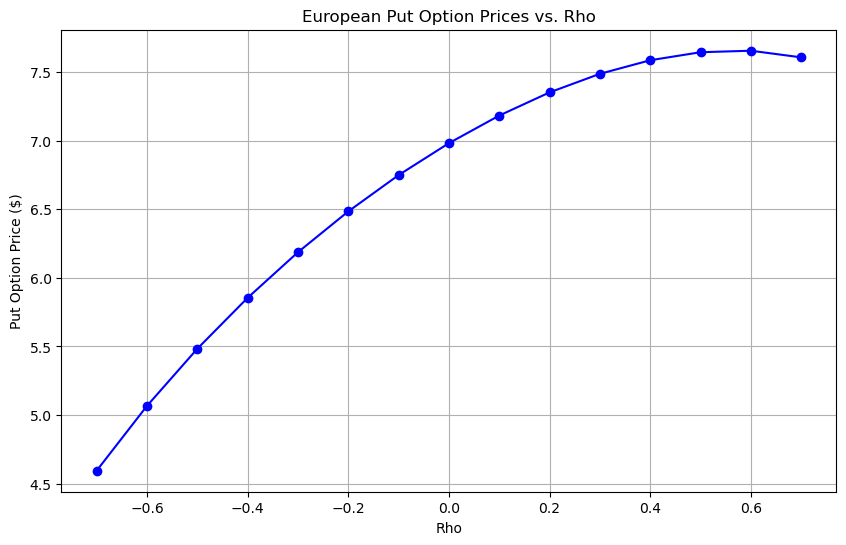

In [61]:
def european_put_option_price(T, S, K, a, b, sigma, eta, phi, initial_rate, x0, y0, rho, num_simulations, num_steps, seed):
    put_option_prices = []

    for j in range(num_simulations):
        rates = np.zeros(num_steps + 1)
        x = np.zeros(num_steps + 1)
        y = np.zeros(num_steps + 1)
        x[0] = x0
        y[0] = y0
        rates[0] = initial_rate
        for i in range(1, num_steps + 1):
            Z1 = np.random.normal()
            Z2 = np.random.normal()
            x[i] = x[i-1] + (-a * x[i-1] * dt) + sigma * np.sqrt(dt) * Z1
            y[i] = y[i-1] + (-b * y[i-1] * dt) + eta * (rho * Z1 + np.sqrt(1 - rho**2) * Z2) * np.sqrt(dt)
            rates[i] = x[i] + y[i] + phi
        R = -np.sum(rates) * dt
        P_value = simulate_g2pp(T=S, num_simulations=100, num_steps=1000, a=a, b=b, sigma=sigma, eta=eta, phi=phi, initial_rate=rates[-1], x0=x0, y0=y0, rho=rho, seed=seed) * 1000
        payoff = max(K - P_value, 0)
        put_option_prices.append(np.exp(R) * payoff)

    return np.mean(put_option_prices)

# Parameters
K = 950
T = 0.5
S = 1.0
num_steps = 1000
num_simulations = 1000
initial_rate = 0.055
x0 = 0
y0 = 0
a = 0.1
b = 0.3
sigma = 0.05
eta = 0.09
phi = 0.055
seed = 57

rho_values = np.arange(-0.7, 0.8, 0.1)
put_option_prices = []

for rho in rho_values:
    price = european_put_option_price(T=T, S=S, K=K, a=a, b=b, sigma=sigma, eta=eta, phi=phi, initial_rate=initial_rate, x0=x0, y0=y0, rho=rho, num_simulations=num_simulations, num_steps=num_steps, seed=seed)
    put_option_prices.append(price)
    print(f"Put option price for rho={rho}: ${price:.4f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(rho_values, put_option_prices, marker='o', linestyle='-', color='b')
plt.title('European Put Option Prices vs. Rho')
plt.xlabel('Rho')
plt.ylabel('Put Option Price ($)')
plt.grid(True)
plt.show()

Put option price for rho=-0.7: $1.0132
Put option price for rho=-0.6: $1.4928
Put option price for rho=-0.5: $1.9407
Put option price for rho=-0.4: $2.3539
Put option price for rho=-0.30000000000000004: $2.7778
Put option price for rho=-0.20000000000000007: $3.2053
Put option price for rho=-0.10000000000000009: $3.6045
Put option price for rho=-1.1102230246251565e-16: $3.9887
Put option price for rho=0.09999999999999987: $4.3794
Put option price for rho=0.19999999999999984: $4.7748
Put option price for rho=0.2999999999999998: $5.1506
Put option price for rho=0.3999999999999998: $5.5128
Put option price for rho=0.4999999999999998: $5.8654
Put option price for rho=0.5999999999999998: $6.2451
Put option price for rho=0.6999999999999997: $6.6713


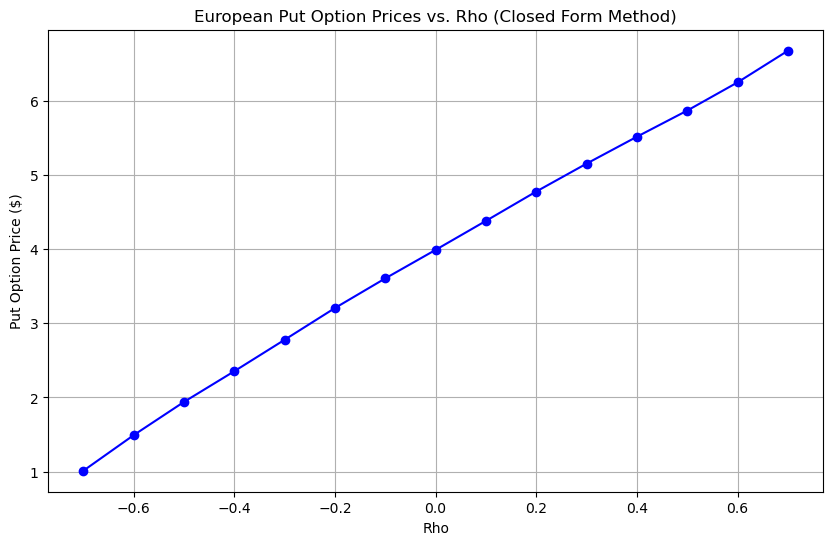

In [82]:
from scipy.integrate import quad

# Define the parameters
a = 0.1
b = 0.3
sigma = 0.05
eta = 0.09
T = 0.5
t = 0.0
xt = 0
yt = 0
phi_t = 0.055
face_value = 1000
K = 950
S = 1
N = 1000
M = 1000
seed = 57

# Define the function φ(u)
def phi(u):
    return 0.055

# Define the V(t, T) function
def V(t, T, a, b, sigma, eta, rho):
    term1 = (sigma ** 2 / a ** 2) * (T - t + (2 / a) * np.exp(-a * (T - t)) - (1 / (2 * a)) * np.exp(-2 * a * (T - t)) - (3 / (2 * a)))
    term2 = (eta ** 2 / b ** 2) * (T - t + (2 / b) * np.exp(-b * (T - t)) - (1 / (2 * b)) * np.exp(-2 * b * (T - t)) - (3 / (2 * b)))
    term3 = (2 * rho * sigma * eta / (a * b)) * (T - t + (np.exp(-a * (T - t)) - 1) / a + (np.exp(-b * (T - t)) - 1) / b - (np.exp(-(a + b) * (T - t)) - 1) / (a + b))
    return term1 + term2 + term3

# Define the integrand for φ(u)
def integrand(u):
    return phi(u)

def G_closed_form(a, b, sigma, eta, rho, t, T, xt, yt):
    # Calculate V(t, T)
    VtT = V(t, T, a, b, sigma, eta, rho)
    
    # Integrate φ(u) from t to T
    integral_phi, _ = quad(integrand, t, T)
    
    # Calculate the price of the zero-coupon bond
    P_t_T = np.exp(-integral_phi - (1 - np.exp(-a * (T - t))) / a * xt - (1 - np.exp(-b * (T - t))) / b * yt + 0.5 * VtT)
    
    return P_t_T

def european_put_option(x0, y0, phi_t, sigma, eta, rho, a, b, t, T, N, M):
    option_prices = []
    dt = T / M
    np.random.seed(seed)
    N1 = np.random.normal(0, 1, (N, M))
    N2 = rho * N1 + np.sqrt(1 - (rho ** 2)) * np.random.normal(0, 1, (N, M))

    for path in range(N):
        Z1 = N1[path]
        Z2 = N2[path]

        x_steps = np.zeros(M + 1)
        y_steps = np.zeros(M + 1)
        r_steps = np.zeros(M + 1)

        x_steps[0] = x0
        y_steps[0] = y0

        for i in range(M):
            x_steps[i + 1] = x_steps[i] + -a * (dt) * (x_steps[i]) + (sigma * np.sqrt(dt) * Z1[i])
            y_steps[i + 1] = y_steps[i] + -b * (dt) * (y_steps[i]) + (eta * np.sqrt(dt) * Z2[i])

            r_steps[i + 1] = x_steps[i + 1] + y_steps[i + 1] + phi_t

        R_T = -np.sum(r_steps[:-1]) * dt
        
        P_T = G_closed_form(a, b, sigma, eta, rho, T, S, x_steps[i + 1], y_steps[i + 1]) * face_value

        payoff = np.max([K - P_T, 0])
        option_prices.append(np.exp(R_T) * payoff)

    return np.mean(option_prices)

# Calculate the European put option prices with varying rho
rho_values = np.arange(-0.7, 0.8, 0.1)
put_option_prices_hybrid = []

for rho in rho_values:
    price_hybrid = european_put_option(x0=xt, y0=yt, phi_t=phi_t, sigma=sigma, eta=eta, rho=rho, a=a, b=b, t=0, T=T, N=N, M=M)
    put_option_prices_hybrid.append(price_hybrid)
    print(f"Put option price for rho={rho}: ${price_hybrid:.4f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(rho_values, put_option_prices_hybrid, marker='o', linestyle='-', color='b')
plt.title('European Put Option Prices vs. Rho (Closed Form Method)')
plt.xlabel('Rho')
plt.ylabel('Put Option Price ($)')
plt.grid(True)
plt.show()

## Lecture 9, 10 [MBS]

### Q.5 (a)

In [48]:
def CIR_model(kappa, mean_rate, sigma, prev_rate):
    h1 = np.sqrt(kappa ** 2 + 2 * sigma ** 2)
    h2 = (kappa + h1) / 2
    h3 = 2 * kappa * mean_rate / sigma ** 2
    B_T1T2 = (np.exp(h1 * 10) - 1) / (h2 * (np.exp(h1 * 10) - 1) + h1)
    temp = h1 * np.exp(h2 * 10) / (h2 * (np.exp(h1 * 10) - 1) + h1)
    A_T1T2 = np.power(temp, h3)
    rate_10yr = -np.log(A_T1T2 * np.exp(-B_T1T2 * prev_rate)) / 10
    return rate_10yr

def CPR_step(WAC, prev_rate, prev_pv, initial_pv, sigma, kappa, mean_rate, SG_t, SY_t):
    rate_10yr = CIR_model(kappa=kappa, mean_rate=mean_rate, sigma=sigma, prev_rate=prev_rate)
    RI_t = 0.28 + 0.14 * np.arctan(-8.57 + 430 * (WAC - rate_10yr))
    BU_t = 0.3 + 0.7 * prev_pv / initial_pv
    return RI_t * BU_t * SG_t * SY_t

def MBS_price(T=30, L0=100000, WAC=0.08, initial_rate=0.078, kappa=0.6, mean_rate=0.08, sigma=0.12, rho=0.0, seed=57):
    dt = 1 / 120  # Time interval
    n_months = int(12 * T)
    M = 2000
    num_steps = int(round(T / dt))
    
    # Interest rate simulation
    np.random.seed(seed)
    rates = np.zeros((M, num_steps + 1))
    rates[:, 0] = initial_rate
    
    for i in range(num_steps):
        Z1 = np.random.normal(0, 1, M)
        Z2 = np.random.normal(0, 1, M)
        Z = rho * Z1 + np.sqrt(1 - rho**2) * Z2
        rates[:, i + 1] = rates[:, i] + kappa * (mean_rate - rates[:, i]) * dt + sigma * np.sqrt(np.abs(rates[:, i])) * np.sqrt(dt) * Z
    
    # Cash flows and present value calculations
    discount_factors = np.zeros((M, n_months))
    SY = np.zeros(n_months)
    present_values = np.zeros((M, n_months))
    present_values[:, 0] = L0
    cash_flows = np.zeros((M, n_months))
    monthly_rate = WAC / 12
    
    for i in range(n_months):
        discount_factors[:, i] = np.sum(rates[:, 1:(10 * i + 11)], axis=1) * (-dt)
        prev_rate_i = rates[:, 10 * i]
        SG_i = np.minimum(1, (i + 1) / 30)
        
        if i % 12 == 0:
            SY[i:(i + 12)] = np.array([0.94, 0.76, 0.74, 0.95, 0.98, 0.92, 0.98, 1.10, 1.18, 1.22, 1.23, 0.98])
        
        CPR_i = CPR_step(WAC=WAC, prev_rate=prev_rate_i, prev_pv=present_values[:, i], initial_pv=L0, sigma=sigma, kappa=kappa, mean_rate=mean_rate, SG_t=SG_i, SY_t=SY[i])
        
        cash_flows[:, i] = present_values[:, i] * monthly_rate / (1 - np.power(1 + monthly_rate, i - n_months)) + (present_values[:, i] - present_values[:, i] * monthly_rate * (1 / (1 - np.power(1 + monthly_rate, i - n_months)) - 1)) * (1 - np.power((1 - CPR_i), 1 / 12))
        
        TPP_i = present_values[:, i] * monthly_rate * (1 / (1 - np.power(1 + monthly_rate, i - n_months)) - 1) + (present_values[:, i] - present_values[:, i] * monthly_rate * (1 / (1 - np.power(1 + monthly_rate, i - n_months)) - 1)) * (1 - np.power((1 - CPR_i), 1 / 12))
        
        if i < (n_months - 1):
            present_values[:, i + 1] = present_values[:, i] - TPP_i
    
    discount_factors = np.exp(discount_factors)
    MBS_price = np.mean(np.sum(np.multiply(discount_factors, cash_flows), axis=1))
    return MBS_price

Do you want to use the default values for the parameters? (yes/no):  yes


MBS price for mean_rate=0.04: $108834.53
MBS price for mean_rate=0.05: $106641.29
MBS price for mean_rate=0.060000000000000005: $105360.67
MBS price for mean_rate=0.07: $105054.86
MBS price for mean_rate=0.08000000000000002: $100342.59
MBS price for mean_rate=0.09000000000000001: $95229.10
MBS price for mean_rate=0.1: $90496.61
MBS price for mean_rate=0.11000000000000001: $86194.67


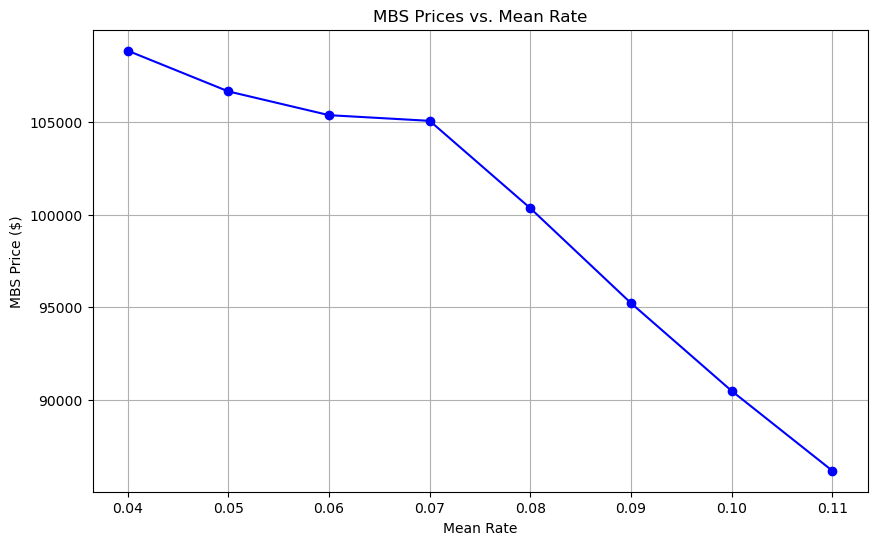

In [83]:
# asking the user if they want to input their own values
use_default = input("Do you want to use the default values for the parameters? (yes/no): ").strip().lower()

if use_default == "no":
    T = float(input("Enter the maturity (T) in years (default 30): ").strip() or 30)
    L0 = float(input("Enter the notional amount of the pool (L0) in dollars (default 100000): ").strip() or 100000)
    WAC = float(input("Enter the weighted-average-coupon (WAC) as a decimal (default 0.08): ").strip() or 0.08)
    initial_rate = float(input("Enter the initial interest rate (r0) as a decimal (default 0.078): ").strip() or 0.078)
    kappa = float(input("Enter the mean reversion rate (kappa) (default 0.6): ").strip() or 0.6)
    sigma = float(input("Enter the volatility (sigma) (default 0.12): ").strip() or 0.12)
    rho = float(input("Enter the correlation (rho) as a decimal (default 0.0): ").strip() or 0.0)
    seed = int(input("Enter the seed for random number generation (default 57): ").strip() or 57)
else:
    T = 30
    L0 = 100000
    WAC = 0.08
    initial_rate = 0.078
    kappa = 0.6
    mean_rate = 0.08
    sigma = 0.12
    rho = 0.0
    seed = 57

mean_rate_values = np.arange(0.04, 0.11, 0.01)
mbs_prices = []

for mean_rate in mean_rate_values:
    price = MBS_price(T=T, L0=L0, WAC=WAC, initial_rate=initial_rate, kappa=kappa, mean_rate=mean_rate, sigma=sigma, rho=rho, seed=seed)
    mbs_prices.append(price)
    print(f"MBS price for mean_rate={mean_rate}: ${price:.2f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(mean_rate_values, mbs_prices, marker='o', linestyle='-', color='b')
plt.title('MBS Prices vs. Mean Rate')
plt.xlabel('Mean Rate')
plt.ylabel('MBS Price ($)')
plt.grid(True)
plt.show()

### Q.5 (b)

In [19]:
def OAS_MBS(market_price, T=30, L0=100000, WAC=0.08, initial_rate=0.078, kappa=0.6, mean_rate=0.08, sigma=0.12, seed=57):
    dt = 1 / 120
    n_months = int(12 * T)
    M = 2000
    num_steps = int(round(T / dt))
    
    # Interest rate simulation
    np.random.seed(seed)
    rates = np.zeros((M, num_steps + 1))
    rates[:, 0] = initial_rate
    
    for i in range(num_steps):
        Z = np.random.normal(0, 1, M)
        rates[:, i + 1] = rates[:, i] + kappa * (mean_rate - rates[:, i]) * dt + sigma * np.sqrt(np.abs(rates[:, i])) * np.sqrt(dt) * Z
    
    # Cash flows and present value calculations
    discount_factors = np.zeros((M, n_months))
    SY = np.zeros(n_months)
    present_values = np.zeros((M, n_months))
    present_values[:, 0] = L0
    cash_flows = np.zeros((M, n_months))
    indices = np.zeros((M, n_months))
    monthly_rate = WAC / 12
    
    for i in range(n_months):
        discount_factors[:, i] = np.sum(rates[:, 1:(10 * i + 11)], axis=1) * (-dt)
        prev_rate_i = rates[:, 10 * i]
        SG_i = np.minimum(1, (i + 1) / 30)
        
        if i % 12 == 0:
            SY[i:(i + 12)] = np.array([0.94, 0.76, 0.74, 0.95, 0.98, 0.92, 0.98, 1.10, 1.18, 1.22, 1.23, 0.98])
        
        CPR_i = CPR_step(WAC=WAC, prev_rate=prev_rate_i, prev_pv=present_values[:, i], initial_pv=L0, sigma=sigma, kappa=kappa, mean_rate=mean_rate, SG_t=SG_i, SY_t=SY[i])
        
        cash_flows[:, i] = present_values[:, i] * monthly_rate / (1 - np.power(1 + monthly_rate, i - n_months)) + (present_values[:, i] - present_values[:, i] * monthly_rate * (1 / (1 - np.power(1 + monthly_rate, i - n_months)) - 1)) * (1 - np.power((1 - CPR_i), 1 / 12))
        
        TPP_i = present_values[:, i] * monthly_rate * (1 / (1 - np.power(1 + monthly_rate, i - n_months)) - 1) + (present_values[:, i] - present_values[:, i] * monthly_rate * (1 / (1 - np.power(1 + monthly_rate, i - n_months)) - 1)) * (1 - np.power((1 - CPR_i), 1 / 12))
        
        indices[:, i] = i
        if i < (n_months - 1):
            present_values[:, i + 1] = present_values[:, i] - TPP_i
    
    def fx(oas):
        return np.mean(np.sum(np.multiply(np.exp(discount_factors - indices * oas * 10 * dt), cash_flows), axis=1)) - market_price
    
    oas = fsolve(fx, 0)
    return oas[0]

OAS_Spread = OAS_MBS(market_price=98000) * 100
print(f"Given the market price of $98,000, the OAS is: {OAS_Spread:.4f}%")

Given the market price of $98,000, the OAS is: 0.3686%


### Q.5 (c)

In [20]:
def IO_PO(T=30, L0=100000, WAC=0.08, initial_rate=0.078, kappa=0.6, mean_rate=0.08, sigma=0.12, seed=57):
    dt = 1 / 120
    n_months = int(12 * T)
    M = 2000
    num_steps = int(round(T / dt))
    
    # Interest rate simulation
    np.random.seed(seed)
    rates = np.zeros((M, num_steps + 1))
    rates[:, 0] = initial_rate
    Interest = np.zeros((M, n_months))
    Principal = np.zeros((M, n_months))
    present_values_prev = np.array([L0] * M)
    
    for i in range(num_steps):
        Z = np.random.normal(0, 1, M)
        rates[:, i + 1] = rates[:, i] + kappa * (mean_rate - rates[:, i]) * dt + sigma * np.sqrt(np.abs(rates[:, i])) * np.sqrt(dt) * Z
    
    discount_factors = np.zeros((M, n_months))
    SY = np.zeros(n_months)
    present_values = np.zeros((M, n_months))
    present_values[:, 0] = L0
    cash_flows = np.zeros((M, n_months))
    monthly_rate = WAC / 12

    for i in range(n_months):
        discount_factors[:, i] = np.sum(rates[:, 1:(10 * i + 11)], axis=1) * (-dt)
        prev_rate_i = rates[:, 10 * i]
        SG_i = np.minimum(1, (i + 1) / 30)
        
        if i % 12 == 0:
            SY[i:(i + 12)] = np.array([0.94, 0.76, 0.74, 0.95, 0.98, 0.92, 0.98, 1.10, 1.18, 1.22, 1.23, 0.98])
        
        CPR_i = CPR_step(WAC=WAC, prev_rate=prev_rate_i, prev_pv=present_values[:, i], initial_pv=L0, sigma=sigma, kappa=kappa, mean_rate=mean_rate, SG_t=SG_i, SY_t=SY[i])
        
        cash_flows[:, i] = present_values[:, i] * monthly_rate / (1 - np.power(1 + monthly_rate, i - n_months)) + (present_values[:, i] - present_values[:, i] * monthly_rate * (1 / (1 - np.power(1 + monthly_rate, i - n_months)) - 1)) * (1 - np.power((1 - CPR_i), 1 / 12))
        
        TPP_i = cash_flows[:, i] - present_values[:, i] * monthly_rate
        Interest[:, i] = present_values[:, i] * monthly_rate
        Principal[:, i] = TPP_i
        
        if i < (n_months - 1):
            present_values[:, i + 1] = present_values[:, i] - TPP_i
    
    discount_factors = np.exp(discount_factors)
    IO = np.mean(np.sum(np.multiply(discount_factors, Interest), axis=1))
    PO = np.mean(np.sum(np.multiply(discount_factors, Principal), axis=1))    
    return IO, PO

IO_price, PO_price = IO_PO(T=30, L0=100000, WAC=0.08, initial_rate=0.078, kappa=0.6, mean_rate=0.08, sigma=0.12)
print(f"The price of the IO tranche using the Numerix model is: ${IO_price:.2f}")
print(f"The price of the PO tranche using the Numerix model is: ${PO_price:.2f}")

The price of the IO tranche using the Numerix model is: $53477.04
The price of the PO tranche using the Numerix model is: $46928.87
